# Evaluating Cartpole Model

In [9]:
#| output: false
## Environment and packages
# cd(@__DIR__)
# using Pkg; Pkg.activate("."); Pkg.instantiate()

using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Simulate Data from New Configuration

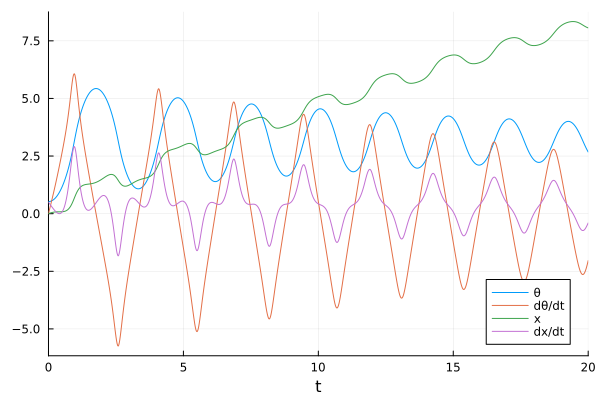

In [90]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
p = (1.5, 1.0, 9.8, 1.0, 0.05, 0.1, 1/3)

# Initial conditions
u0 = [0.524, 0.0, 0.0, 0.5]  # 30 degrees, 0.5 m/s to the right
# u0 = [0.0, 3.0, 0.0, 2.0]  # Pend straight up (0 deg), moving 3 rad/s clockwise, cart moving 2 m/s to the left

tspan = (0.0,20.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol, label=["θ" "dθ/dt" "x" "dx/dt"])

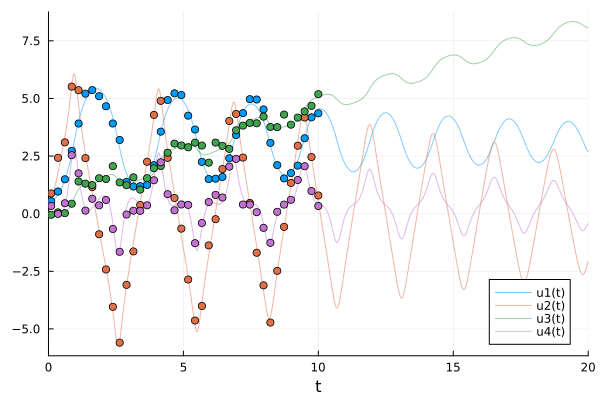

In [98]:
#| output: false
t = collect(range(0.1, stop=10, length=40))

odedata = Array(solve(probCart, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2 3 4], label="")


## Use Chain to generate predictions


In [46]:
path = "../../learnedModels/bayesianSindy/chain-cartpole-hs-hard-laplace-good.jls"
chain = read(path, Chains);

In [91]:
#| output: false
function cartpoleSindy!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    θ, θ̇, x, ẋ = u

    # theta_d and x_d
    du[1] = θ̇
    du[3] = ẋ

    # theta_dd
    θ̈ = (p[1]*sin(θ) +
         p[2]*cos(θ) + 
         p[3]*θ̇ + 
         p[4]*ẋ +
         p[5]*θ̇ *sin(θ)+ 
         p[6]*ẋ *sin(θ)+ 
         p[7]*ẋ *θ̇ + 
         p[8]*cos(θ) *sin(θ)+ 
         p[9]*ẋ *cos(θ)+ 
         p[10]*cos(θ) *θ̇ + 
         p[11]*cos(θ)^2+ 
         p[12]*sin(θ)^2+ 
         p[13]*θ̇ ^2+ 
         p[14]*ẋ^2+
         p[36])
    du[2] = θ̈ 

    # x_dd
    du[4] = (p[15]*sin(θ) +
             p[16]*cos(θ)+ 
             p[17]*θ̇ + 
             p[18]*θ̈  +
             p[19]*ẋ +
             p[20]*θ̇ *sin(θ)+ 
             p[21]*ẋ *sin(θ)+ 
             p[22]*ẋ *θ̇+ 
             p[23]*θ̈ *sin(θ)+ 
             p[24]*ẋ *θ̈ + 
             p[25]*θ̈  *θ̇+ 
             p[26]*ẋ *cos(θ)+ 
             p[27]*cos(θ) *θ̇+ 
             p[28]*cos(θ) *sin(θ)+ 
             p[29]*cos(θ) *θ̈ + 
             p[30]*sin(θ)^2+ 
             p[31]*cos(θ)^2+ 
             p[32]*θ̇ ^2+ 
             p[33]*θ̈  ^2+ 
             p[34]*ẋ^2 +
             p[35])
end

cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:36])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [92]:
#| output: false
@model function genQuantities(::Type{T} = Float64) where {T <: Real}
    # Initialize theta
    priors = [Laplace(0.0, 0.1) for i in 1:36]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end    
    p = convert.(T, theta)
    
    # Initialize sigma
    σ ~ InverseGamma(2, 0.5)
    
    # Solve DE
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    # predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    # failure = size(predicted, 2) < length(t)

    # if failure
    #     Turing.@addlogprob! -Inf
    #     return
    # end

    return (; predicted_dense)
end


genQuantities (generic function with 3 methods)

In [93]:
#| output: false
using DataFramesMeta

model = genQuantities()
finnish_chain = generated_quantities(model, MCMCChains.get_sections(chain, :parameters))#[1:10, :, :])
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2));

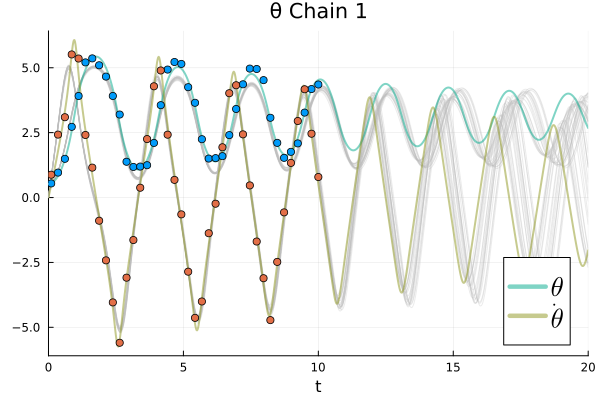

In [100]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
# for i in 1:1:10
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=2, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


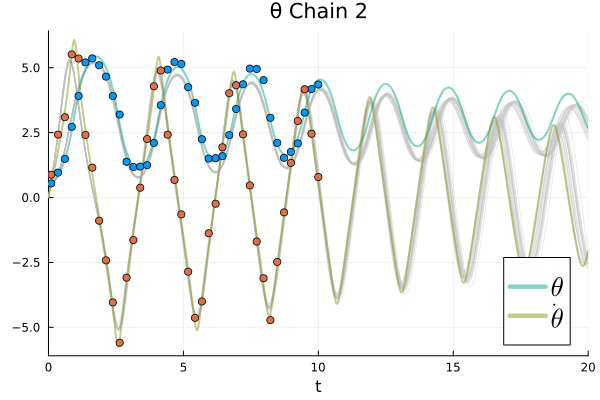

In [101]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
# for i in 11:1:20
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end


# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=2, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


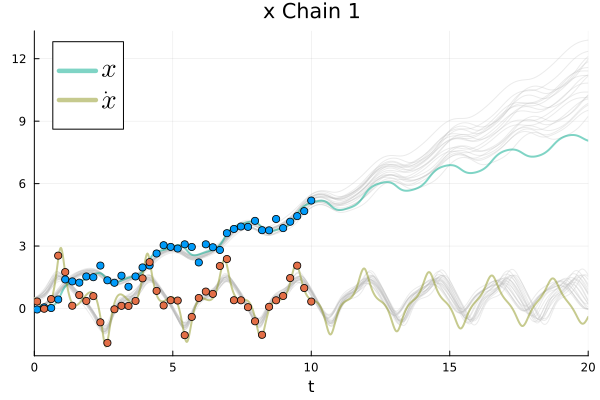

In [102]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
# for i in 1:1:10
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=2, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


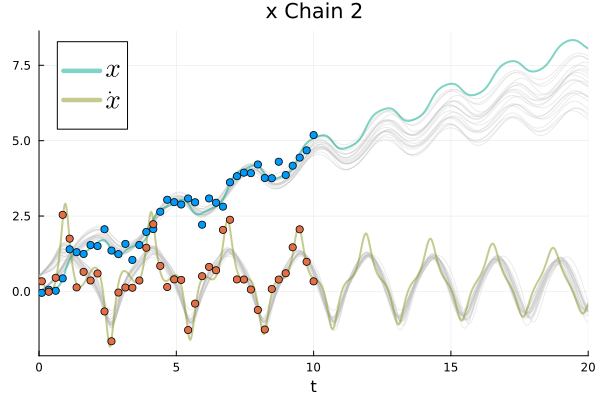

In [103]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
# for i in 11:1:20
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=2, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")
